In [1]:
# Install latest Tensorflow build
%load_ext tensorboard

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


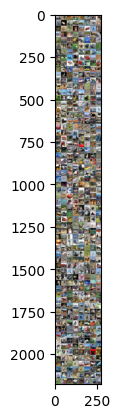

truck bird  horse dog   bird  ship  plane cat   plane cat   bird  truck plane frog  plane cat   frog  frog  horse dog   horse truck bird  cat   car   cat   cat   deer  horse plane horse frog  frog  ship  horse frog  dog   plane deer  bird  bird  horse frog  dog   dog   cat   truck deer  bird  bird  ship  deer  deer  horse truck horse dog   deer  plane cat   ship  truck truck bird  frog  ship  frog  dog   truck bird  deer  truck deer  horse bird  horse deer  car   horse dog   plane horse frog  bird  truck plane car   car   bird  ship  horse plane car   plane plane cat   horse bird  plane cat   dog   bird  bird  plane deer  plane plane cat   ship  bird  frog  ship  bird  dog   truck frog  horse dog   car   ship  frog  car   frog  ship  ship  cat   horse plane truck plane car   cat   bird  frog  ship  bird  cat   horse dog   bird  deer  plane cat   cat   car   truck horse truck dog   car   plane car   car   cat   deer  cat   horse frog  car   ship  bird  dog   deer  car   plane horse frog

In [10]:

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
# ##################################################################################################
# Aufgabe 2
# ##################################################################################################

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)         # 32x32 -> 30x30
        self.conv2 = nn.Conv2d(8, 16, 3)        # 30x30 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)          # 28x28 -> 14x14
        self.conv3 = nn.Conv2d(16, 32, 3)       # 14x14 -> 12x12
        self.conv4 = nn.Conv2d(32, 64, 3)       # 12x12 -> 10x10
                                                # 10x10 -> 5x5
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
# set device to cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
print(device)

cuda


In [16]:
writer = SummaryWriter()

for epoch in range(10):  # loop over the dataset multiple times

    print("Epoch:", epoch, flush=True)
    print("Batches:", len(trainloader))

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 0:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', flush=True)
            running_loss = 0

writer.flush()

print('Finished Training')

Epoch: 0
Batches: 3125
[1,     1] loss: 0.001
[1,    21] loss: 0.023
[1,    41] loss: 0.023
[1,    61] loss: 0.023
[1,    81] loss: 0.023
[1,   101] loss: 0.023
[1,   121] loss: 0.023
[1,   141] loss: 0.023
[1,   161] loss: 0.023
[1,   181] loss: 0.023
[1,   201] loss: 0.023
[1,   221] loss: 0.023
[1,   241] loss: 0.023
[1,   261] loss: 0.023
[1,   281] loss: 0.023
[1,   301] loss: 0.023
[1,   321] loss: 0.023
[1,   341] loss: 0.023
[1,   361] loss: 0.023
[1,   381] loss: 0.023
[1,   401] loss: 0.023
[1,   421] loss: 0.023
[1,   441] loss: 0.023
[1,   461] loss: 0.023
[1,   481] loss: 0.023
[1,   501] loss: 0.022
[1,   521] loss: 0.023
[1,   541] loss: 0.023
[1,   561] loss: 0.022
[1,   581] loss: 0.022
[1,   601] loss: 0.022
[1,   621] loss: 0.022
[1,   641] loss: 0.021
[1,   661] loss: 0.022
[1,   681] loss: 0.022
[1,   701] loss: 0.021
[1,   721] loss: 0.022
[1,   741] loss: 0.022
[1,   761] loss: 0.021
[1,   781] loss: 0.021
[1,   801] loss: 0.021
[1,   821] loss: 0.021
[1,   841] 

# Aufgabe 3 / 4

CPU                | Nvidia 1050  | Nvidia 3060    |
-------------------|------------- | -------------- |
26 min 6 s (colab) | 3 min 54 s   | 1 min 3 s      |
4 min 14 s (lokal) |              |                |

In [17]:
# ##################################################################################################
# Aufgabe 5
# ##################################################################################################

correct              = 0
total                = 0
correct_top_3        = 0

correct_pred = {classname: 0 for classname in classes}
total_pred   = {classname: 0 for classname in classes}

ground_truths = []
predictions   = []

wrong_top_3 = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader):
        images, labels = data
        labels = labels.to(device)

        outputs = net(images.to(device))

        for i in range(len(outputs)):
            predictions.append(outputs[i].cpu().numpy())
            ground_truths.append(labels[i].cpu().numpy())

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Top-3 accuracy
        _, predicted_top3 = torch.topk(outputs, 3, 1)
        for i in range(len(predicted_top3)):
            if labels[i] in predicted_top3[i]:
                correct_top_3 += 1
                correct_pred[classes[labels[i]]] += 1
            else:
                wrong_top_3.append((images[i], labels[i], predicted[i]))

        for i in range(len(predicted)):
            total_pred[classes[labels[i]]] += 1

ground_truths = np.array(ground_truths)
predictions   = np.array(predictions)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
print(f'Top-3 accuracy of the network on the 10000 test images: {100 * correct_top_3 // total} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Top3 Accuracy for class: {classname:6s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 67 %
Top-3 accuracy of the network on the 10000 test images: 89 %
Top3 Accuracy for class: plane  is 92.9 %
Top3 Accuracy for class: car    is 96.0 %
Top3 Accuracy for class: bird   is 83.3 %
Top3 Accuracy for class: cat    is 80.5 %
Top3 Accuracy for class: deer   is 90.5 %
Top3 Accuracy for class: dog    is 91.5 %
Top3 Accuracy for class: frog   is 92.1 %
Top3 Accuracy for class: horse  is 87.1 %
Top3 Accuracy for class: ship   is 93.0 %
Top3 Accuracy for class: truck  is 92.6 %


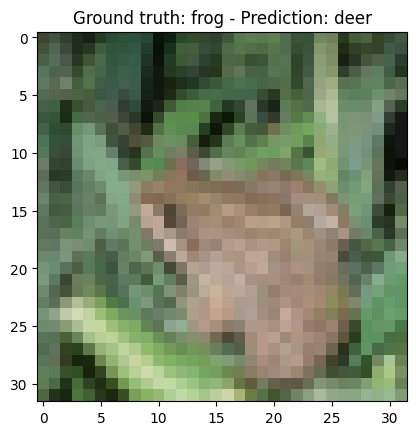

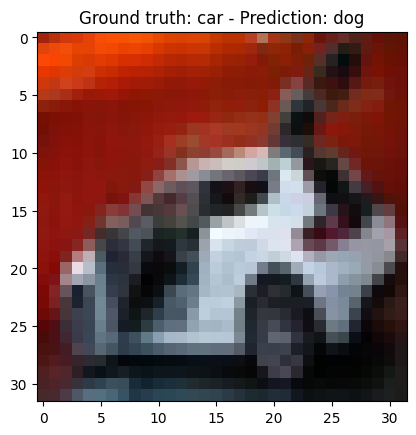

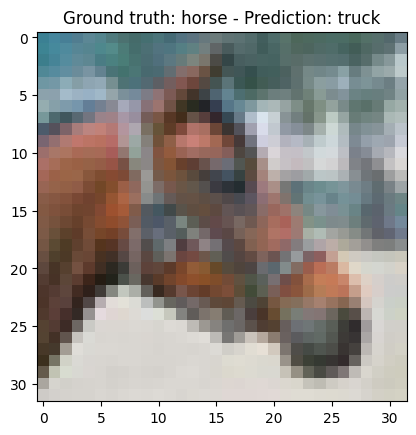

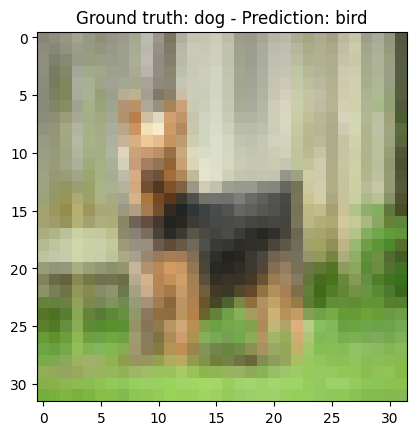

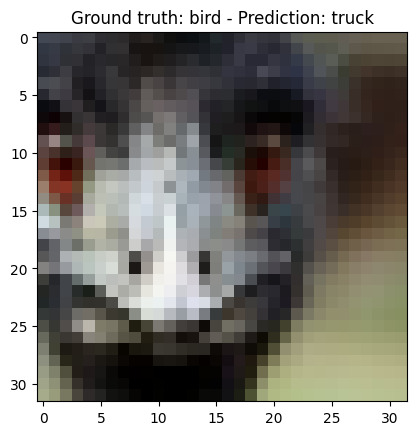

In [18]:
# Aufgabe 6
# ##################################################################################################

for i in range(5):
    img, label, pred = wrong_top_3[i]
    img = img / 2 + 0.5 # unnormalize the tensor to an image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Ground truth: {classes[label]} - Prediction: {classes[pred]}')
    plt.show()

    # Write the image to tensorboard
    writer.add_image(f'GT: {classes[label]} PRED: {classes[pred]}', img, i)

In [19]:
# ##################################################################################################
# Aufgabe 7
# ##################################################################################################
%tensorboard --logdir=runs